In [ ]:
!pip install segmentation-models-pytorch==0.1.2         # easy to use some famous model architecture. visit https://github.com/qubvel/segmentation_models.pytorch/
!pip install albumentations                             # easy image manipulation for data augmentation
!pip install -U git+https://github.com/lRomul/argus.git  # easy training model
!pip install pytorch-toolbelt

     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 163kB 35.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=bf1203ec9a753ee6dd9842ddf300542a57783840bb8f180efedfd79869141902
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=98735ca3af64cf7b1f4d5cba7afb2b5e16f94873db4d6c2ea505bf21acd79e05
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch
     |████████████████████████████████| 634kB 19.6MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=4616bb307cea18b53c5194bdb197f87805394df14ce636d9b8c04aebd4c015f7
  Store

In [ ]:
from copy import copy

import numpy as np

import torch
torch.backends.cudnn.benchmark = True
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

from pytorch_toolbelt.losses import LovaszLoss

import segmentation_models_pytorch as smp
import argus
from argus.callbacks import MonitorCheckpoint, EarlyStopping, LoggingToFile, ReduceLROnPlateau, LoggingToCSV
from argus.metrics import Metric
import albumentations as A


from sklearn.metrics import multilabel_confusion_matrix
import time

In [ ]:
def _prf_divide(numerator, denominator, ):
    """Performs division and handles divide-by-zero.
    On zero-division, sets the corresponding result elements equal to
    0 or 1 (according to ``zero_division``). 
    """
    mask = denominator == 0.0
    denominator = denominator.copy()
    denominator[mask] = 1  # avoid infs/nans
    result = numerator / denominator

    return result

def compute_scores(y_true, y_pred, class_weights=[1, 1, 1, 1, 20, 20]):
    """
    Computes the weighted & unweighted f1_score and accuracy
    Using the standard F1-Score and class-wise accuracy computations were quite 
    slow as we were doing a lot of redundant work across all score computations,
    hence we have implemented this from the base principles.
    Please refer to the inline comments.
    """

    # Initial Housekeeping Taks1
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    class_weights = np.array(class_weights)
    # print(np.max(y_true))
    # print(np.max(y_pred))
    # print(np.min(y_true))
    # print(np.min(y_pred))
    # Computing Multilabel Confusion Matrix
    #print("--------- Computing MCM... ")
    begin_time = time.time()
    MCM = multilabel_confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5,6])
    #print("MCM computation time  : ", time.time() - begin_time)
    
    """
    Gather True Positives, True Negatives, False Positives, False Negatives
    """
    tp_sum = MCM[:, 1, 1]
    tn_sum = MCM[:, 0, 0]
    fn_sum = MCM[:, 1, 0]
    fp_sum = MCM[:, 0, 1]
    
    #print("--------- Computing per class instances... ")
    per_class_instances = np.bincount(y_true) # Helps keep a track of total number of instances per class
    per_class_instances = per_class_instances[1:] # as the class names in the dataset are NOT zero-indexed
    
    assert class_weights.shape == per_class_instances.shape
    
    #print("--------- Computing precision... ")
    # precision : tp / (tp + fp)
    precision = _prf_divide(
                    tp_sum,
                    (tp_sum + fp_sum)
                )
    #print("--------- Computing recall... ")                        
    # recall : tp / (tp + fn)
    recall = _prf_divide(
                    tp_sum,
                    (tp_sum + fn_sum)
                )

    #print("--------- Computing F1 score... ")
    # f1 : 2 * (recall * precision) / (recall + precision)
    f1_score = _prf_divide(
                    2 * precision * recall,
                    precision + recall
                )
    #print("--------- Computing Accuracy... ")
    # accuracy = tp_sum / instances_per_class
    # NOTE: we are computing the accuracy independently for all the class specific subgroups
    # accuracy = _prf_divide(
    #                 tp_sum,
    #                 per_class_instances
    #             )
    # print(class_weights)
    # print(f1_score)
    f1_score_weighted = np.dot(class_weights, f1_score) / np.sum(class_weights)
    f1_score_unweighted = f1_score.mean()

    # accuracy_weighted = np.dot(class_weights, accuracy) / np.sum(class_weights)
    # accuracy_unweighted = accuracy.mean()

    return f1_score_weighted#, accuracy_weighted, f1_score_unweighted, accuracy_unweighted

class CategoricalAccuracy(Metric):
    """Calculates the accuracy for multiclass classification."""

    name = 'f1facies'
    better = 'max'

    def __init__(self):
        self.score = 0

    def reset(self):
        self.score = 0

    def update(self, step_output: dict):
        # preds = step_output['prediction'].cpu().numpy()
        preds = step_output['prediction'].max(1)[1].cpu().numpy()[:, :, :]+1
        # print(preds[0,:,:])
        # print(preds.shape)
        trgs = step_output['target'].cpu().numpy()+1
        # print(trgs[0,:,:])
        # print(trgs.shape)
        self.score =  compute_scores(trgs, preds)

    def compute(self):

        return self.score

In [ ]:
class LovaszBCELoss(torch.nn.Module):
    def __init__(self, lovasz_weight=0.75, ce_weight=0.25):
        super().__init__()
        self.lovasz_weight = lovasz_weight
        self.ce_weight = ce_weight
        self.ce = torch.nn.CrossEntropyLoss()
        self.lovasz = LovaszLoss()

    def forward(self, output, target):
        if self.lovasz_weight > 0:
            lovasz = self.lovasz(torch.softmax(output, dim=1), target) * self.lovasz_weight
        else:
            lovasz = 0

        if self.ce_weight > 0:
            ce = self.ce(output, target.long()) * self.ce_weight
        else:
            ce = 0

        return lovasz + ce

In [ ]:
#data that processed then rescaled to 0-1 (check main explainer)
!gdown "https://drive.google.com/uc?id=19Ku7UMjvWhwJ1_7Ii7_AaF5Eoyl-24ul"
!gdown "https://drive.google.com/uc?id=1HL0bwFIhUx8A25644JbmpozNQ0jwmWCT"
!gdown "https://drive.google.com/uc?id=1o8lvBdvsh3-sI3dsE-p6H9SNzFbY_ksC"
!gdown "https://drive.google.com/uc?id=1b5MoCr0VoRG_6R_h1JO7dx6mZgO6Zz8J"
!gdown "https://drive.google.com/uc?id=1hYCxIJIgbow6IYpIxwAJXdfiloC8PFYq"
!gdown "https://drive.google.com/uc?id=1JZ5LZz_f2Vfg9BxuGGBY9LliJQAAHi_H"
!gdown "https://drive.google.com/uc?id=1--tADAa10l2M1iaSEslGXK-RaBv8UbMf"

Downloading...
From: https://drive.google.com/uc?id=19Ku7UMjvWhwJ1_7Ii7_AaF5Eoyl-24ul
To: /content/data_train_procsed.npz
1.62GB [00:15, 105MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1HL0bwFIhUx8A25644JbmpozNQ0jwmWCT
To: /content/data_174_251_trainolah.npz
5.91MB [00:00, 18.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o8lvBdvsh3-sI3dsE-p6H9SNzFbY_ksC
To: /content/label_174_251_train.npz
100% 28.7k/28.7k [00:00<00:00, 4.21MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b5MoCr0VoRG_6R_h1JO7dx6mZgO6Zz8J
To: /content/data_test2_75_174_olahnorm.npz
5.90MB [00:00, 52.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hYCxIJIgbow6IYpIxwAJXdfiloC8PFYq
To: /content/label75_174_test_round2.npz
100% 27.1k/27.1k [00:00<00:00, 3.99MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JZ5LZz_f2Vfg9BxuGGBY9LliJQAAHi_H
To: /content/data_train_processed.npz
1.73GB [00:35, 48.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--tADAa10l2M1

In [ ]:
train_dat = np.load('data_train_procsed.npz', allow_pickle=True, mmap_mode='r')['data'].astype('float32')
train_labels = np.load('labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']

#confidence pseudolabels that we got from round 1
ex_dat = np.load('data_174_251_trainolah.npz', allow_pickle=True, mmap_mode='r')['data'].astype('float32')
ex_labels = np.load('label_174_251_train.npz', allow_pickle=True, mmap_mode='r')['label']

#appending the data
train_dat = np.append(train_dat,ex_dat[:,841-782:,:],axis=2)
train_labels = np.append(train_labels,ex_labels[:,841-782:,:],axis=2)

#confidence pseudolabels that got from error map round 2
test_dat = np.load('data_test2_75_174_olahnorm.npz', allow_pickle=True, mmap_mode='r')['data']
test_labels = np.load('label75_174_test_round2.npz', allow_pickle=True, mmap_mode='r')['label']

train_dat=train_dat.transpose(1, 0, 2)
train_labels=train_labels.transpose(1, 0, 2)
test_dat=test_dat.transpose(2, 0, 1)
test_labels=test_labels.transpose(2, 0, 1)
train_labels -= 1
test_labels -= 1

In [ ]:
#setting dataset
class DataGeneratorTrain(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set
        self.xaxis = self.x.shape[0]
        self.yaxis = self.x.shape[2]
        self.aug = A.Compose([
            #A.RandomSizedCrop(p=1.0, min_max_height=(1006, 1006), height=1006, width=256, w2h_ratio=1.0, interpolation=0),
            A.RandomCrop(1006, 130, p=1.0),
            A.ShiftScaleRotate(p=0.5, shift_limit=(0.0, 0.0), scale_limit=(0.01, 0.25), rotate_limit=(-15, 15), interpolation=0, border_mode=1),
            A.Resize(p=1, height=1000, width=128, interpolation=0)
            
        ]) 
        self.aug2 = A.Compose([
            #A.RandomSizedCrop(p=1.0, min_max_height=(1006, 1006), height=1006, width=256, w2h_ratio=1.0, interpolation=0),
            A.RandomCrop(1006, 130, p=1.0),
            #A.Blur(p=1.0, blur_limit=(3, 3))
            # A.flip()
            A.ShiftScaleRotate(p=0.5, shift_limit=(0.0, 0.0), scale_limit=(0.01, 0.25), rotate_limit=(-3, 3), interpolation=0, border_mode=1),
            A.Resize(p=1, height=1000, width=128, interpolation=0)
            
        ])  

    def __len__(self):
        return self.xaxis+self.yaxis
    
    def __getitem__(self, index):   
        if index < self.xaxis:
            batch_x = self.x[index,:,:]
            batch_y = self.y[index]

        else:
            batch_x = self.x[:,:,index-len(self.x)].T
            batch_y = self.y[:,:,index-len(self.x)].T

        augmented = self.aug(image=batch_x, mask=batch_y)

        image, mask = augmented['image'], augmented['mask']

        return image[None,:,:], mask

class DataGeneratorTest(Dataset):
    def __init__(self, x_set, y_set):
        self.x, self.y = x_set, y_set
        self.aug = A.Compose([
            A.Resize(p=1, height=1000, width=128, interpolation=0)
        ])        

    def __len__(self):
        return int(np.ceil(self.x.shape[2]/130)*2)#len(self.x)*
    
    def __getitem__(self, index):
        idx=int(np.floor(index/np.ceil(self.x.shape[2]/130)))
        idy=int(index%np.ceil(self.x.shape[2]/130))
        
        if idy==int(self.x.shape[2]/130):
            batch_x = self.x[idx,:,self.x.shape[2]-130:]
            batch_y = self.y[idx,:,self.x.shape[2]-130:]
        else:
            batch_x = self.x[idx,:,idy*130:idy*130+130]
            batch_y = self.y[idx,:,idy*130:idy*130+130]

        augmented = self.aug(image=batch_x, mask=batch_y)
        image, mask = augmented['image'], augmented['mask']

        return image[None,:,:], mask

In [ ]:
#setting the architecture, losses, optimizer, etc.
class SeismicFaciesModel(argus.Model):
    nn_module = smp.PAN
    optimizer = optim.Adam
    loss = LovaszBCELoss

params = {
    'nn_module': {
        'encoder_name': 'efficientnet-b3',
        'classes': 6,
        'in_channels': 1,
        'encoder_weights': None,
        'activation': None
    },
    'loss': {
        'lovasz_weight': 0.75,
        'ce_weight': 0.25,
    },
    'optimizer': {'lr': 0.0009},
    'device': 'cuda'
}

In [ ]:
def get_data_loaders(batch_size):
    train_dataset = DataGeneratorTrain(x_set=train_dat,y_set=train_labels) 
    test_dataset = DataGeneratorTest(x_set=test_dat,y_set=test_labels) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=14, shuffle=True) 
    return train_loader, test_loader

In [ ]:
bsize=6
train_loader, val_loader= get_data_loaders(batch_size=bsize)
model = SeismicFaciesModel(params)

In [ ]:
callbacks = [
    MonitorCheckpoint(dir_path=f'panet_r1', monitor='val_f1facies', max_saves=25),
    ReduceLROnPlateau(monitor='val_loss', patience=30, factor=0.64, min_lr=1e-8),
    EarlyStopping(monitor='val_loss', patience=50),
    LoggingToFile(f'panet_r1.log'),
    LoggingToCSV(f'panet_r1.csv')
]

In [ ]:
#this will take forefer..
model.fit(train_loader,
      val_loader=val_loader,
      num_epochs=200,
      metrics=['f1facies'],
      callbacks=callbacks,
      metrics_on_train=False)

[2021-02-10 07:19:16,138][INFO]: val - epoch: -1, val_loss: 1.072965, val_f1facies: 0.01064363
[2021-02-10 07:20:37,849][INFO]: train - epoch: 0, lr: 0.0009, train_loss: 0.8203805
[2021-02-10 07:20:38,382][INFO]: val - epoch: 0, val_loss: 0.9873087, val_f1facies: 0.01345567
[2021-02-10 07:20:38,490][INFO]: Model saved to 'panet_r1/model-000-0.013456.pth'
[2021-02-10 07:21:59,209][INFO]: train - epoch: 1, lr: 0.0009, train_loss: 0.7320742
[2021-02-10 07:21:59,745][INFO]: val - epoch: 1, val_loss: 0.9373235, val_f1facies: 0.05616276
[2021-02-10 07:21:59,868][INFO]: Model saved to 'panet_r1/model-001-0.056163.pth'
[2021-02-10 07:23:21,143][INFO]: train - epoch: 2, lr: 0.0009, train_loss: 0.7168491
[2021-02-10 07:23:21,692][INFO]: val - epoch: 2, val_loss: 0.7888632, val_f1facies: 0.7070905
[2021-02-10 07:23:21,804][INFO]: Model saved to 'panet_r1/model-002-0.707091.pth'
[2021-02-10 07:24:44,168][INFO]: train - epoch: 3, lr: 0.0009, train_loss: 0.7072418
[2021-02-10 07:24:44,703][INFO]: va

In [ ]:
#incase you got semi-banned because using gpu too long, here's my checkpoint
!gdown "https://drive.google.com/uc?id=1OTZFF9en1uSYkAZ7NCaFaL4cP-qXdPMP"

Downloading...
From: https://drive.google.com/uc?id=1OTZFF9en1uSYkAZ7NCaFaL4cP-qXdPMP
To: /content/model-097-0.799478.pth
43.7MB [00:02, 21.1MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=1oLCwcBdfJ3SUdKpuq2Cgagrbf1tcRpFZ"

Downloading...
From: https://drive.google.com/uc?id=1oLCwcBdfJ3SUdKpuq2Cgagrbf1tcRpFZ
To: /content/data_test_2_procsed.npz
986MB [00:07, 135MB/s]


In [ ]:
test_dat2 = np.load('data_test_2_procsed.npz', allow_pickle=True, mmap_mode='r')['data']
test_dat2 = test_dat2.transpose(1, 0, 2)

In [ ]:
import cv2
model = argus.load_model('model-097-0.799478.pth')

pred=np.zeros([test_dat2.shape[1],test_dat2.shape[2],test_dat2.shape[0]],dtype=int)
print('predicting...')
for i in range(0,test_dat2.shape[0]):
    for j in range(0,7):
        if j==6:
            tempcek=test_dat2[i,:,test_dat2.shape[2]-130:]
        else: 
            tempcek=test_dat2[i,:,j*130:130+j*130]
        temp=cv2.resize(tempcek, (128,1000), interpolation=cv2.INTER_NEAREST)
        temp=temp[None,None,:,:]
        score = model.predict(torch.from_numpy(temp).float())
        temppred = score.max(1)[1].cpu().numpy()[:, :, :]+1
        temp2 = cv2.resize(temppred[0,:,:], (130,1006), interpolation=cv2.INTER_NEAREST)
        
        if j==6:
            pred[:,test_dat2.shape[2]-130:,i]=temp2
        else: 
            pred[:,j*130:130+j*130,i]=temp2

predicting...


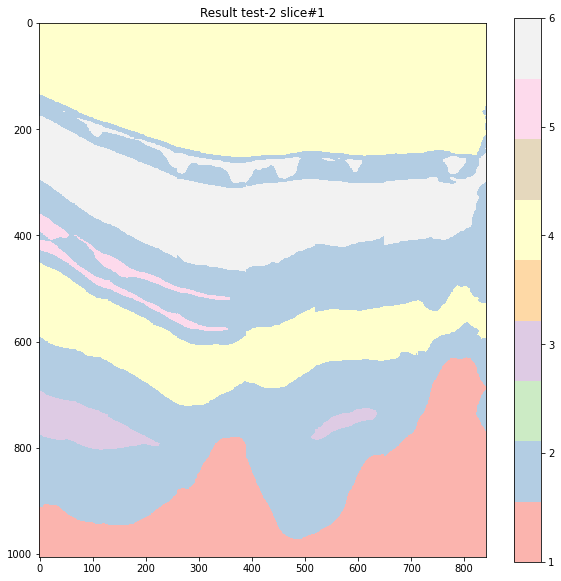

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.imshow(pred[:,:,1],cmap='Pastel1', interpolation='none')
plt.title('Result test-2 slice#1')
plt.colorbar()
plt.show()